## Setup bedrock

In [28]:
import boto3
import json
from botocore.config import Config

boto_config = Config(
    connect_timeout=1, 
    read_timeout=300,
    retries={'max_attempts': 1}
)

boto_session = boto3.Session()

bedrock_runtime = boto_session.client(
    service_name="bedrock-runtime", 
    config=boto_config
)

In [29]:
# generate frame caption
def invoke_claude3(image_base64=None, text_query="What is in this image?"):

    content = []

    img_obj = dict()
    query_obj = {"type": "text", "text": text_query}
        
    if image_base64:
        img_obj["type"] = "image"
        img_obj["source"] = {
            "type": "base64",
            "media_type": "image/jpeg",
            "data": image_base64,
        }
        content.append(img_obj)

    content.append(query_obj)

    body = json.dumps(
        {
            "anthropic_version": "bedrock-2023-05-31",
            "max_tokens": 1000,
            "messages": [
                {
                    "role": "user",
                    "content": content,
                }
            ],
        }
    )

    response = bedrock_runtime.invoke_model(
        modelId="anthropic.claude-3-sonnet-20240229-v1:0",
        body=body)
    
    response_body = json.loads(response.get("body").read())

    return response_body

### Describe Your Story

In [45]:
# Idea of your story
idea="""
A story about a girl trying to catch a monster in their kitchen pantry. She tried booby traps, etc. and finally caught it. It turns out the monster was her cute brother.
"""

## prompt templates
prompt_template="""
    You an expert script writer, take the following story idea and create detail scene description for story boarding.
    
    <story>
    {idea}
    </story>
    
    generate a list of {number} scenes. depict the scene visually with details use less than 100 words. depiction ONLY. NO scene number. seperate the list using |."""

## final prompt
prompt = prompt_template.replace("{idea}", idea).replace("{number}","5")
prompt

'\n    You an expert script writer, take the following story idea and create detail scene description for story boarding.\n    \n    <story>\n    \nA story about a girl trying to catch a monster in their kitchen pantry. She tried booby traps, etc. and finally caught it. It turns out the monster was her cute brother.\n\n    </story>\n    \n    generate a list of 5 scenes. depict the scene visually with details use less than 100 words. depiction ONLY. NO scene number. seperate the list using |.'

### > invoke claude and get scene detail

In [63]:
import re

pattern = r'<(\w+)>(.*?)</\1>'
resp = invoke_claude3(text_query=prompt)
text = resp["content"][0]["text"]

scenes = text.split("|")
new_scenes = []
for s in scenes:
    pattern = r'<(\w+)>(.*?)</\1>'
    match = re.search(pattern, s, re.DOTALL)
    
    # Check if XML tags are present
    if match:
        content = match.group(2).strip()
        new_scenes.append(content)
    else:
        # Remove newline characters
        cleaned_text = s.replace('\n', '').strip()
        if cleaned_text:
            new_scenes.append(cleaned_text)
        else:
            continue
new_scenes

['A dimly lit kitchen, with utensils and boxes strewn about, a trail of crumbs leading to the pantry door, slightly ajar, shadows flickering from within.',
 'The pantry, shelves in disarray, a makeshift trap made of pots and pans, a small figure darting behind cans and boxes.',
 'A little girl, determined expression, wielding a broom like a sword, cautiously approaching the pantry.',
 'A flurry of movement, a shriek of triumph, a tangled mess of limbs and flour-covered figures.',
 "The monster revealed, a mischievous young boy, grinning sheepishly amid the chaos, the girl's exasperated yet amused expression."]

### > generate the story board image for each scene

In [28]:
from PIL import Image
import base64
import io

def _decode(image):
    image = base64.b64decode(image)
    image = Image.open(io.BytesIO(image))
    return image

In [30]:
import random
from tqdm import tqdm

%store -r endpoint_name

smr = boto3.client("sagemaker-runtime")

negative_prompt = "extra digit, fewer digits, cropped, worst quality, low quality, glitch, deformed, mutated, ugly, disfigured"

images = []

for s in tqdm(scenes):
    prompt = f"storyboard sketch of {s}"
    seed = random.randint(0, 100000000)
    response = smr.invoke_endpoint(
        EndpointName=endpoint_name,
        Body=json.dumps(
            {
                "prompt": prompt,
                "nprompt": negative_prompt,
                "seed": seed,
                "steps": 50,
                "h": 1024,
                "w": 1024,
            }
        ),
        ContentType="application/json",
    )
    output = json.loads(response["Body"].read().decode("utf8"))["outputs"]
    images.append(_decode(output))

100%|██████████| 5/5 [01:52<00:00, 22.51s/it]


## Render output

In [33]:
endpoint_name

'endpoint-SDXL-Storyboard-2024-03-16-19-07-53-833'

In [31]:
from IPython.display import Image, display
import matplotlib.pyplot as plt

def display_storyboard(descriptions, images):
    """
    Display a storyboard of tiles in a Jupyter Notebook, with each image having its corresponding description above.
    
    Args:
        descriptions (list): A list of strings representing the descriptions for each image.
        images (list): A list of PIL Image objects.
    """
    if len(descriptions) != len(images):
        raise ValueError("The length of the descriptions and images lists must be the same.")
    
    num_images = len(images)
    fig, axs = plt.subplots(nrows=num_images, ncols=1, figsize=(10, 5 * num_images))
    
    for i, (desc, img) in enumerate(zip(descriptions, images)):
        axs[i].set_axis_off()
        axs[i].text(0.5, 1, desc, ha='left', va='top', wrap=True)
        axs[i].imshow(img)
    
    plt.tight_layout()

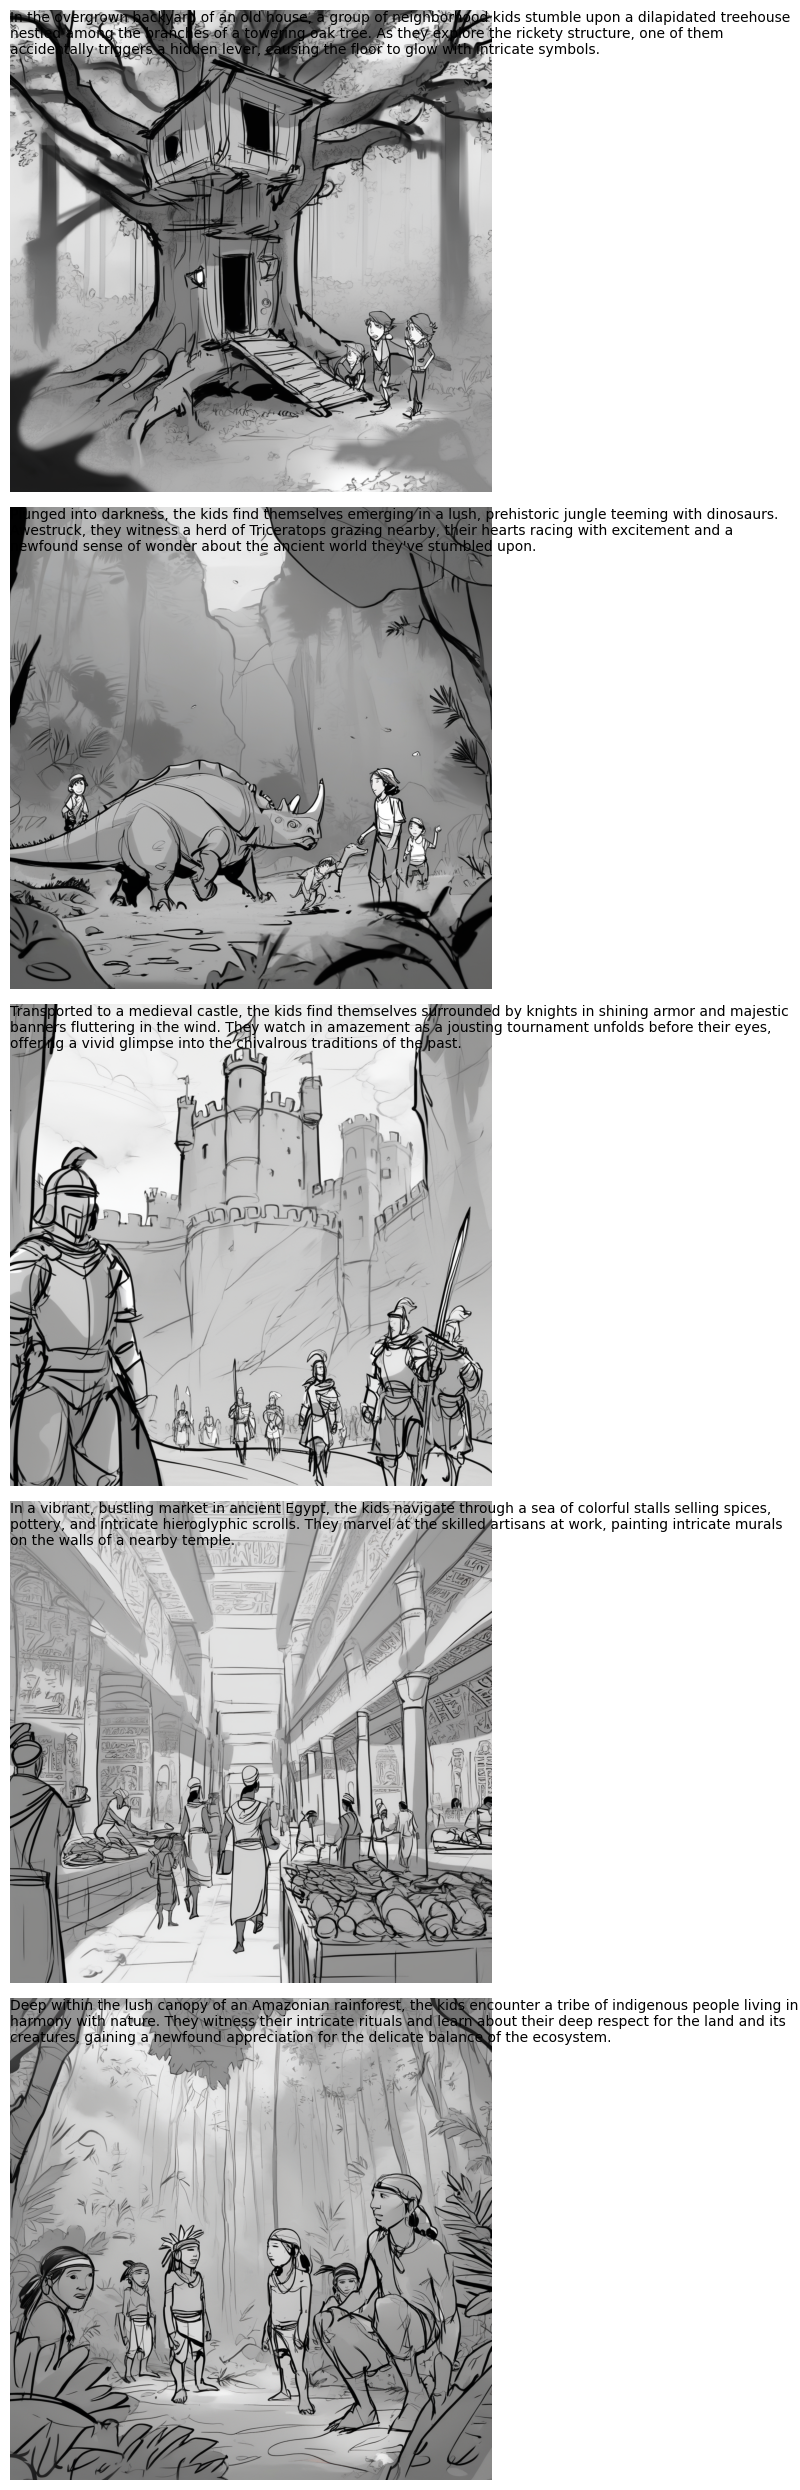

In [32]:
display_storyboard(scenes, images)